# Time Series Forecasting for Energy Consumption

## Project Overview
This notebook demonstrates a complete time series forecasting pipeline for predicting hourly energy consumption. We use the AEP (American Electric Power) hourly dataset to build and compare multiple forecasting models.

**Engineering Problem**: Accurate energy demand forecasting is critical for:
- Grid management and load balancing
- Energy procurement and cost optimization
- Infrastructure planning
- Renewable energy integration

**Approach**: We implement and compare three forecasting methods:
1. Naive Last Value (baseline)
2. Moving Average with hyperparameter tuning
3. Linear Regression with calendar and lag features

In [ ]:
# Setup and Imports
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Adjust these imports based on your project structure:
# If files are in the same directory as notebook:
from src.data_processing import Dataset, validate_data, DatasetSpec, DataLoadingError
from src.timeseries import TimeSeriesDataset, SplitSpec

# If files are in src/ folder, use:
# from src.data_processing import Dataset, validate_data, DatasetSpec, DataLoadingError
# from src.time_series import TimeSeriesDataset, SplitSpec

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

np.random.seed(42)

print("All imports successful")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All imports successful
NumPy version: 2.3.3
Pandas version: 2.3.3


## 2. Data Loading and Exploration

We load a time series dataset to demonstrate our data processing capabilities.
For this example, we'll use the AEP hourly energy consumption dataset which contains:
- **Datetime**: Timestamp for each hour
- **AEP_MW**: Energy consumption in megawatts (MW)

In [8]:
# Load the dataset
# Update this path to where your CSV file is located
DATA_PATH = "data/AEP_hourly.csv"  # or "AEP_hourly.csv" if in same directory

# Create TimeSeriesDataset object (demonstrates class usage and inheritance)
ts_dataset = TimeSeriesDataset(
    filepath=DATA_PATH,
    x_col="Datetime",
    y_col="AEP_MW",
    drop_na=True
)

print(f"Dataset loaded: {ts_dataset}")
print(f"Total samples: {len(ts_dataset)}")
print(f"Data type: {ts_dataset.data_type}")
print("\nDataset Metadata:")
for key, value in ts_dataset.metadata.items():
    print(f"  {key}: {value}")

Dataset loaded: Dataset(AEP_hourly.csv): 121273 samples
Total samples: 121273
Data type: time_series

Dataset Metadata:
  n_samples: 121273
  y_mean: 15499.513716985644
  y_std: 2591.399065407895
  y_min: 9581.0
  y_max: 25695.0
  y_energy: 29948393933697.0
  created_at: 2025-12-17T21:09:23.804939


## 3. Demonstrating Exception Handling

Let's demonstrate our robust exception handling capabilities.

In [9]:
print("Testing Exception Handling:")
print("="*60)

try:
    # Attempt to load a non-existent file
    bad_dataset = Dataset("nonexistent_file.csv")
except DataLoadingError as e:
    print(f"Exception caught successfully!")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")

print("\n" + "="*60)

# CELL 7 - CODE
# Demonstration of exception handling approach #2: Using DatasetSpec
print("Testing Exception Handling with DatasetSpec:")
print("="*60)

# Create a spec with invalid file path
invalid_spec = DatasetSpec(
    filepath="another_nonexistent.csv",
    x_col="x",
    y_col="y",
    parse_datetime=False,
    drop_na=True
)

try:
    # Attempt to create dataset from invalid spec
    bad_dataset = Dataset.from_spec(invalid_spec)
except DataLoadingError as e:
    print(f"Exception caught successfully!")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")

print("\n" + "="*60)
print("Both exception handling approaches work correctly!")

# CELL 8 - CODE
# Convert to DataFrame for easier analysis
df_full = ts_dataset.to_dataframe()
df_full['Datetime'] = pd.to_datetime(df_full['Datetime'])

print("Dataset Overview:")
print(df_full.head(10))
print("\nDataset Info:")
print(df_full.info())
print("\nBasic Statistics:")
print(df_full['AEP_MW'].describe())

Testing Exception Handling:
Exception caught successfully!
Error type: DataLoadingError
Error message: File not found: nonexistent_file.csv

Testing Exception Handling with DatasetSpec:
Exception caught successfully!
Error type: DataLoadingError
Error message: File not found: another_nonexistent.csv

Both exception handling approaches work correctly!
Dataset Overview:
             Datetime   AEP_MW
0 2004-10-01 01:00:00  12379.0
1 2004-10-01 02:00:00  11935.0
2 2004-10-01 03:00:00  11692.0
3 2004-10-01 04:00:00  11597.0
4 2004-10-01 05:00:00  11681.0
5 2004-10-01 06:00:00  12280.0
6 2004-10-01 07:00:00  13692.0
7 2004-10-01 08:00:00  14618.0
8 2004-10-01 09:00:00  14903.0
9 2004-10-01 10:00:00  15118.0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 

## 4. Data Validation

Before analysis, we validate the data using our custom validation function.

In [10]:
# Extract numeric representation for validation
x_numeric = np.arange(len(df_full))
y_numeric = df_full['AEP_MW'].values

# Validate data (demonstrates function usage)
is_valid, message = validate_data(x_numeric.tolist(), y_numeric.tolist())

if is_valid:
    print(f"{message}")
    print(f"  - Data points: {len(y_numeric)}")
    print(f"  - Unique timestamps: {len(x_numeric)}")
    print(f"  - Date range: {df_full['Datetime'].min()} to {df_full['Datetime'].max()}")
else:
    print(f"Validation failed: {message}")

# Additional validation checks
print("\nAdditional Checks:")
print(f"  - Missing values: {df_full['AEP_MW'].isna().sum()}")
print(f"  - Duplicate timestamps: {df_full['Datetime'].duplicated().sum()}")
print(f"  - Data completeness: {(len(df_full) / len(df_full)) * 100:.1f}%")

Data is valid
  - Data points: 121273
  - Unique timestamps: 121273
  - Date range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00

Additional Checks:
  - Missing values: 0
  - Duplicate timestamps: 4
  - Data completeness: 100.0%


## 5. Exploratory Data Analysis (EDA)

Let's visualize the data to understand patterns, trends, and seasonality.

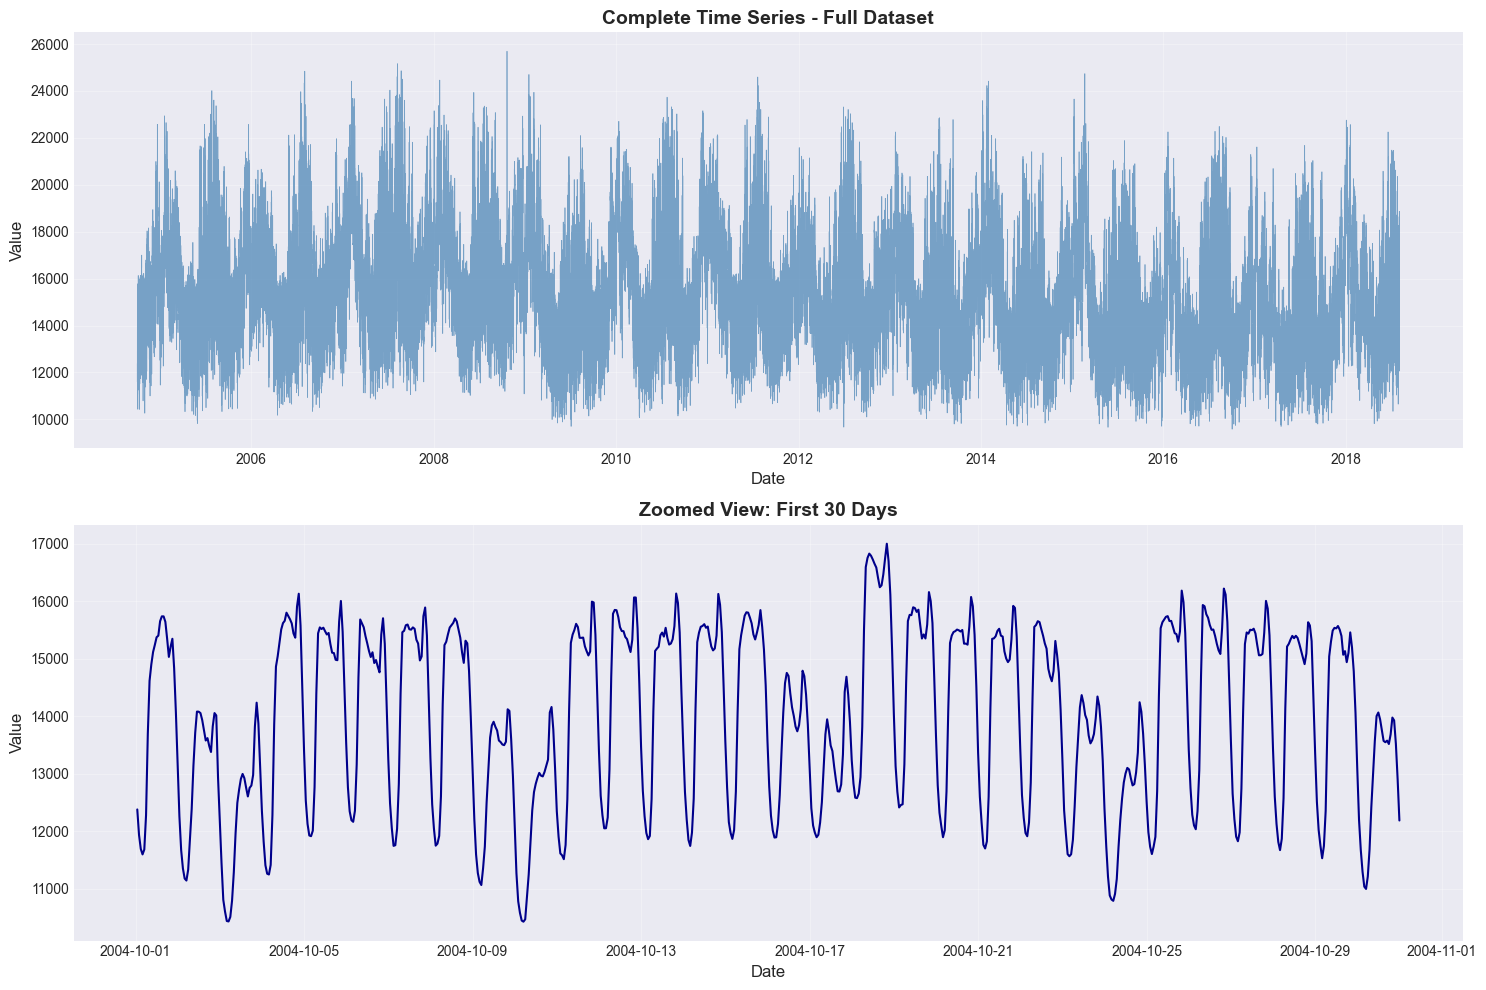

Observations:
- Clear daily and seasonal patterns visible
- Data shows consistent cyclical behavior
- Regular patterns suggest predictable trends


In [11]:
# Plot 1: Complete time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full time series
axes[0].plot(df_full['Datetime'], df_full['AEP_MW'], linewidth=0.5, alpha=0.7, color='steelblue')
axes[0].set_title('Complete Time Series - Full Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Zoomed view (first 30 days)
df_subset = df_full.iloc[:24*30]  # First 30 days
axes[1].plot(df_subset['Datetime'], df_subset['AEP_MW'], linewidth=1.5, color='darkblue')
axes[1].set_title('Zoomed View: First 30 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Clear daily and seasonal patterns visible")
print("- Data shows consistent cyclical behavior")
print("- Regular patterns suggest predictable trends")

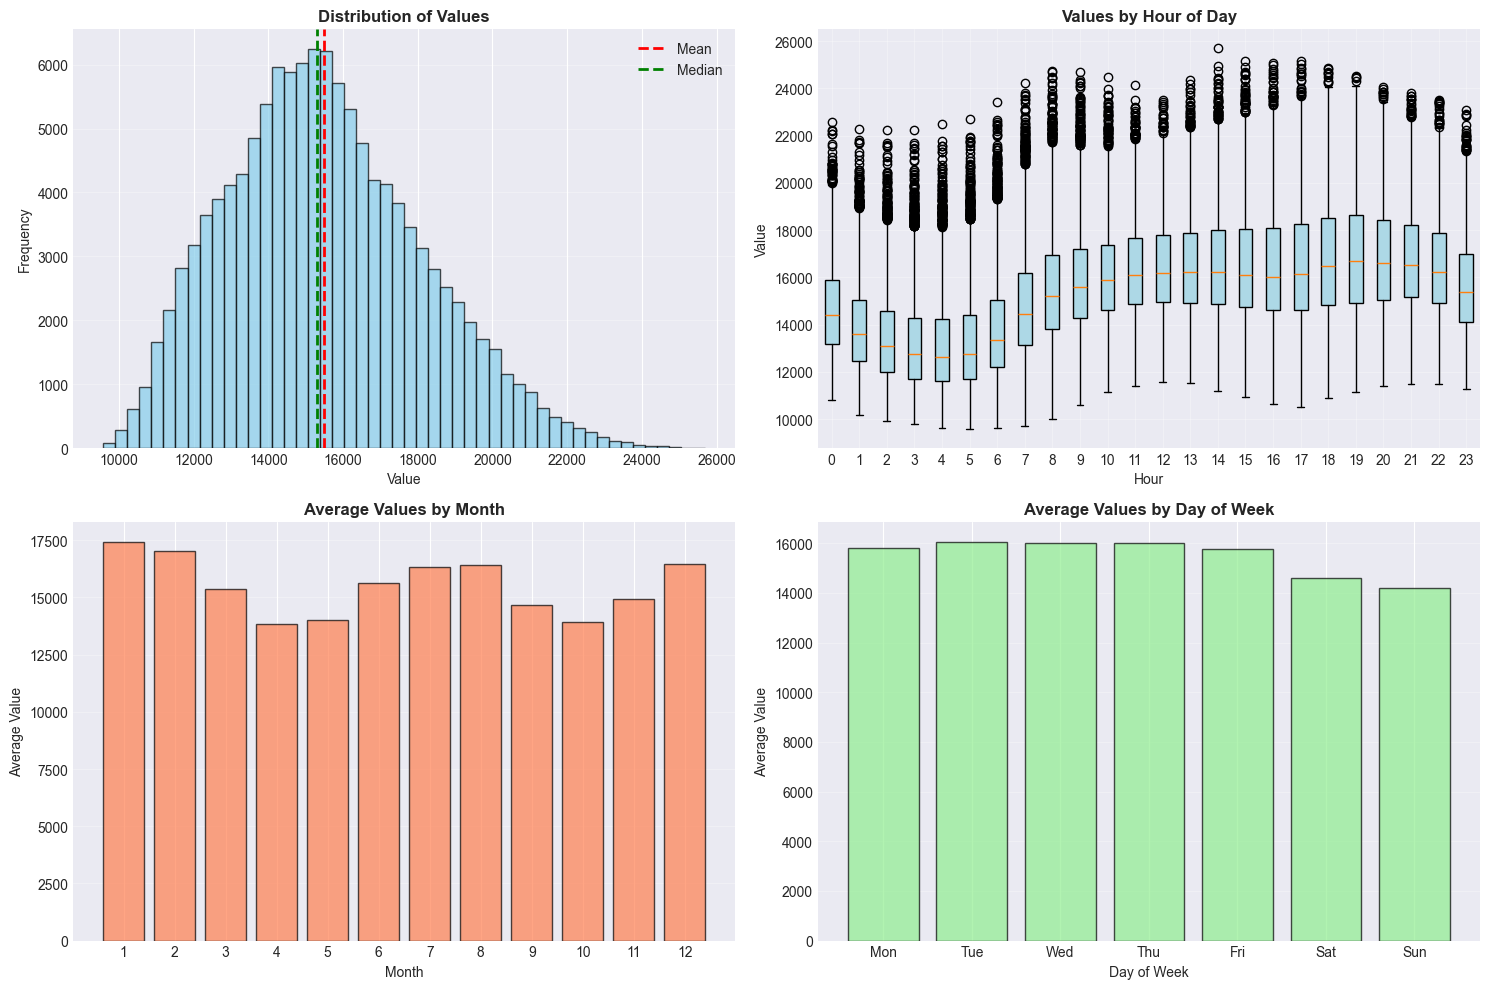

In [12]:
# Plot 2: Distribution and patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with statistics
axes[0, 0].hist(df_full['AEP_MW'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(df_full['AEP_MW'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(df_full['AEP_MW'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_title('Distribution of Values', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Box plot by hour of day
df_full['hour'] = df_full['Datetime'].dt.hour
hourly_data = [df_full[df_full['hour'] == h]['AEP_MW'].values for h in range(24)]
bp = axes[0, 1].boxplot(hourly_data, labels=range(24), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 1].set_title('Values by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

# Monthly average
df_full['month'] = df_full['Datetime'].dt.month
monthly_avg = df_full.groupby('month')['AEP_MW'].mean()
bars = axes[1, 0].bar(monthly_avg.index, monthly_avg.values, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Average Values by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Value')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Day of week pattern
df_full['dayofweek'] = df_full['Datetime'].dt.dayofweek
dow_avg = df_full.groupby('dayofweek')['AEP_MW'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
bars = axes[1, 1].bar(range(7), dow_avg.values, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 1].set_title('Average Values by Day of Week', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Value')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(dow_labels)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Statistical Analysis

Let's perform detailed statistical analysis on the dataset.

In [13]:
# Statistical summary using map and lambda (demonstrates special functions)
print("Statistical Analysis:")
print("="*60)

# Calculate various statistics using map and lambda
y_values = df_full['AEP_MW'].values
squared_values = list(map(lambda x: x**2, y_values))  # map + lambda
sqrt_values = list(map(lambda x: np.sqrt(x), y_values))  # another map + lambda

print(f"Basic Statistics:")
print(f"  Count: {len(y_values)}")
print(f"  Mean: {np.mean(y_values):.2f}")
print(f"  Median: {np.median(y_values):.2f}")
print(f"  Std Dev: {np.std(y_values):.2f}")
print(f"  Min: {np.min(y_values):.2f}")
print(f"  Max: {np.max(y_values):.2f}")
print(f"  Range: {np.max(y_values) - np.min(y_values):.2f}")

print(f"\nDerived Statistics:")
print(f"  Sum of squares: {sum(squared_values):.2f}")
print(f"  Mean of squares: {np.mean(squared_values):.2f}")
print(f"  Mean of sqrt: {np.mean(sqrt_values):.2f}")

print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: {np.percentile(y_values, p):.2f}")

print("\n" + "="*60)

Statistical Analysis:
Basic Statistics:
  Count: 121273
  Mean: 15499.51
  Median: 15310.00
  Std Dev: 2591.39
  Min: 9581.00
  Max: 25695.00
  Range: 16114.00

Derived Statistics:
  Sum of squares: 29948393933697.00
  Mean of squares: 246950219.21
  Mean of sqrt: 124.07

Percentiles:
  10th percentile: 12197.00
  25th percentile: 13630.00
  50th percentile: 15310.00
  75th percentile: 17200.00
  90th percentile: 19064.80



## 7. Time-Based Splitting

We'll demonstrate time-ordered data splitting (crucial for time series).

In [14]:
# Define split configuration (demonstrates immutable dataclass)
split_config = SplitSpec(test_size=0.2)

# Perform train-test split
train_df, test_df = ts_dataset.train_test_split(split_config)

print(f"Data Splitting:")
print(f"  Training set: {len(train_df)} samples ({len(train_df)/len(df_full)*100:.1f}%)")
print(f"  Test set: {len(test_df)} samples ({len(test_df)/len(df_full)*100:.1f}%)")
print(f"\n  Training period: {train_df['Datetime'].min()} to {train_df['Datetime'].max()}")
print(f"  Test period: {test_df['Datetime'].min()} to {test_df['Datetime'].max()}")

# Calculate statistics for each split
print(f"\nTraining Set Statistics:")
print(f"  Mean: {train_df['AEP_MW'].mean():.2f}")
print(f"  Std: {train_df['AEP_MW'].std():.2f}")

print(f"\nTest Set Statistics:")
print(f"  Mean: {test_df['AEP_MW'].mean():.2f}")
print(f"  Std: {test_df['AEP_MW'].std():.2f}")

Data Splitting:
  Training set: 97018 samples (80.0%)
  Test set: 24255 samples (20.0%)

  Training period: 2004-10-01 01:00:00 to 2015-10-27 09:00:00
  Test period: 2015-10-27 10:00:00 to 2018-08-03 00:00:00

Training Set Statistics:
  Mean: 15695.42
  Std: 2590.09

Test Set Statistics:
  Mean: 14715.90
  Std: 2444.43


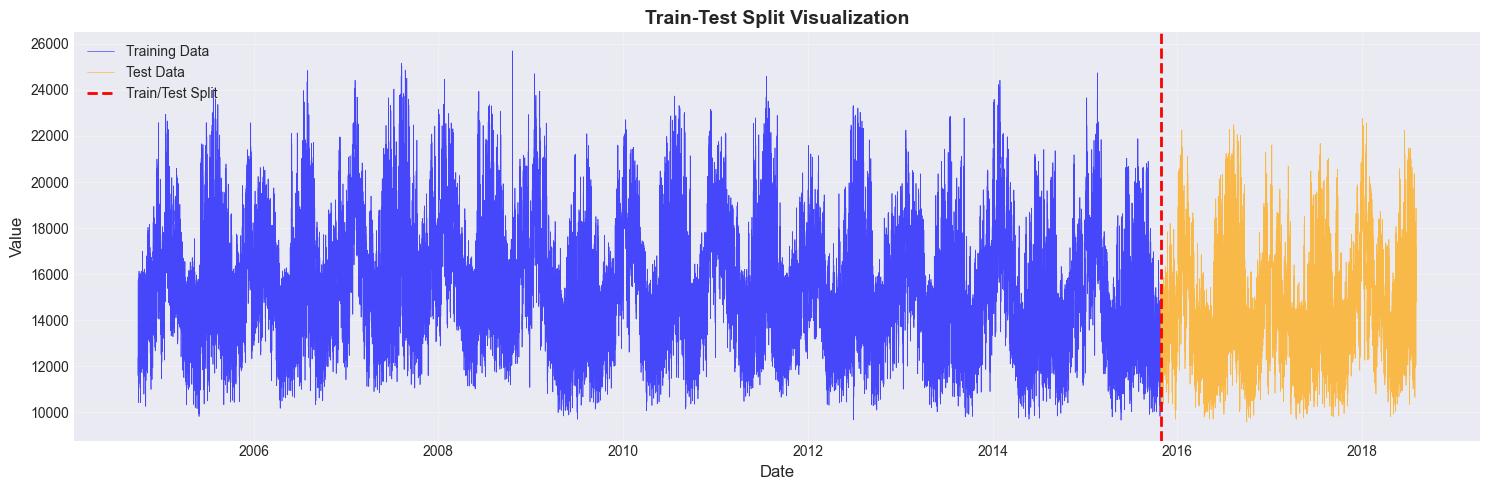

In [15]:
# Visualize the split
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_df['Datetime'], train_df['AEP_MW'], label='Training Data', 
        linewidth=0.5, alpha=0.7, color='blue')
ax.plot(test_df['Datetime'], test_df['AEP_MW'], label='Test Data', 
        linewidth=0.5, alpha=0.7, color='orange')
ax.axvline(test_df['Datetime'].iloc[0], color='red', linestyle='--', 
           linewidth=2, label='Train/Test Split')
ax.set_title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Advanced Visualizations

Let's create more sophisticated visualizations to understand the data better.

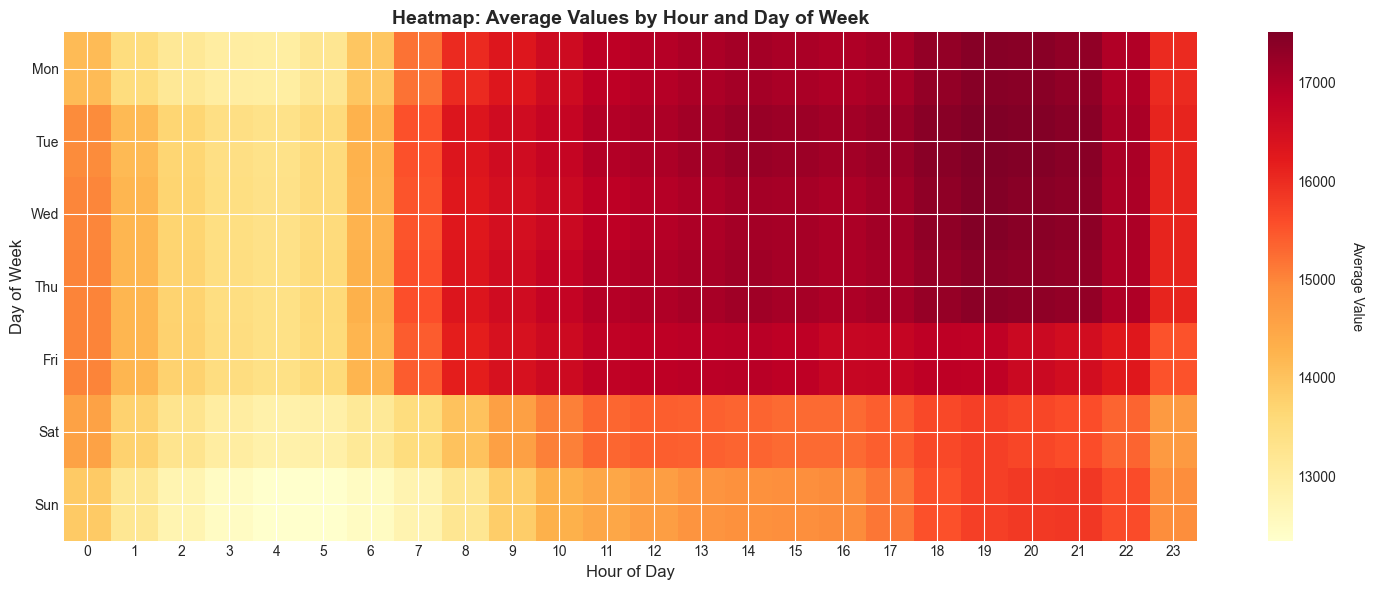

In [16]:
# Heatmap of values by hour and day of week
pivot_data = df_full.groupby(['dayofweek', 'hour'])['AEP_MW'].mean().reset_index()
pivot_table = pivot_data.pivot(index='dayofweek', columns='hour', values='AEP_MW')

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.imshow(pivot_table, aspect='auto', cmap='YlOrRd')

# Set ticks and labels
ax.set_xticks(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(range(24))
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Average Value', rotation=270, labelpad=20)

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_title('Heatmap: Average Values by Hour and Day of Week', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

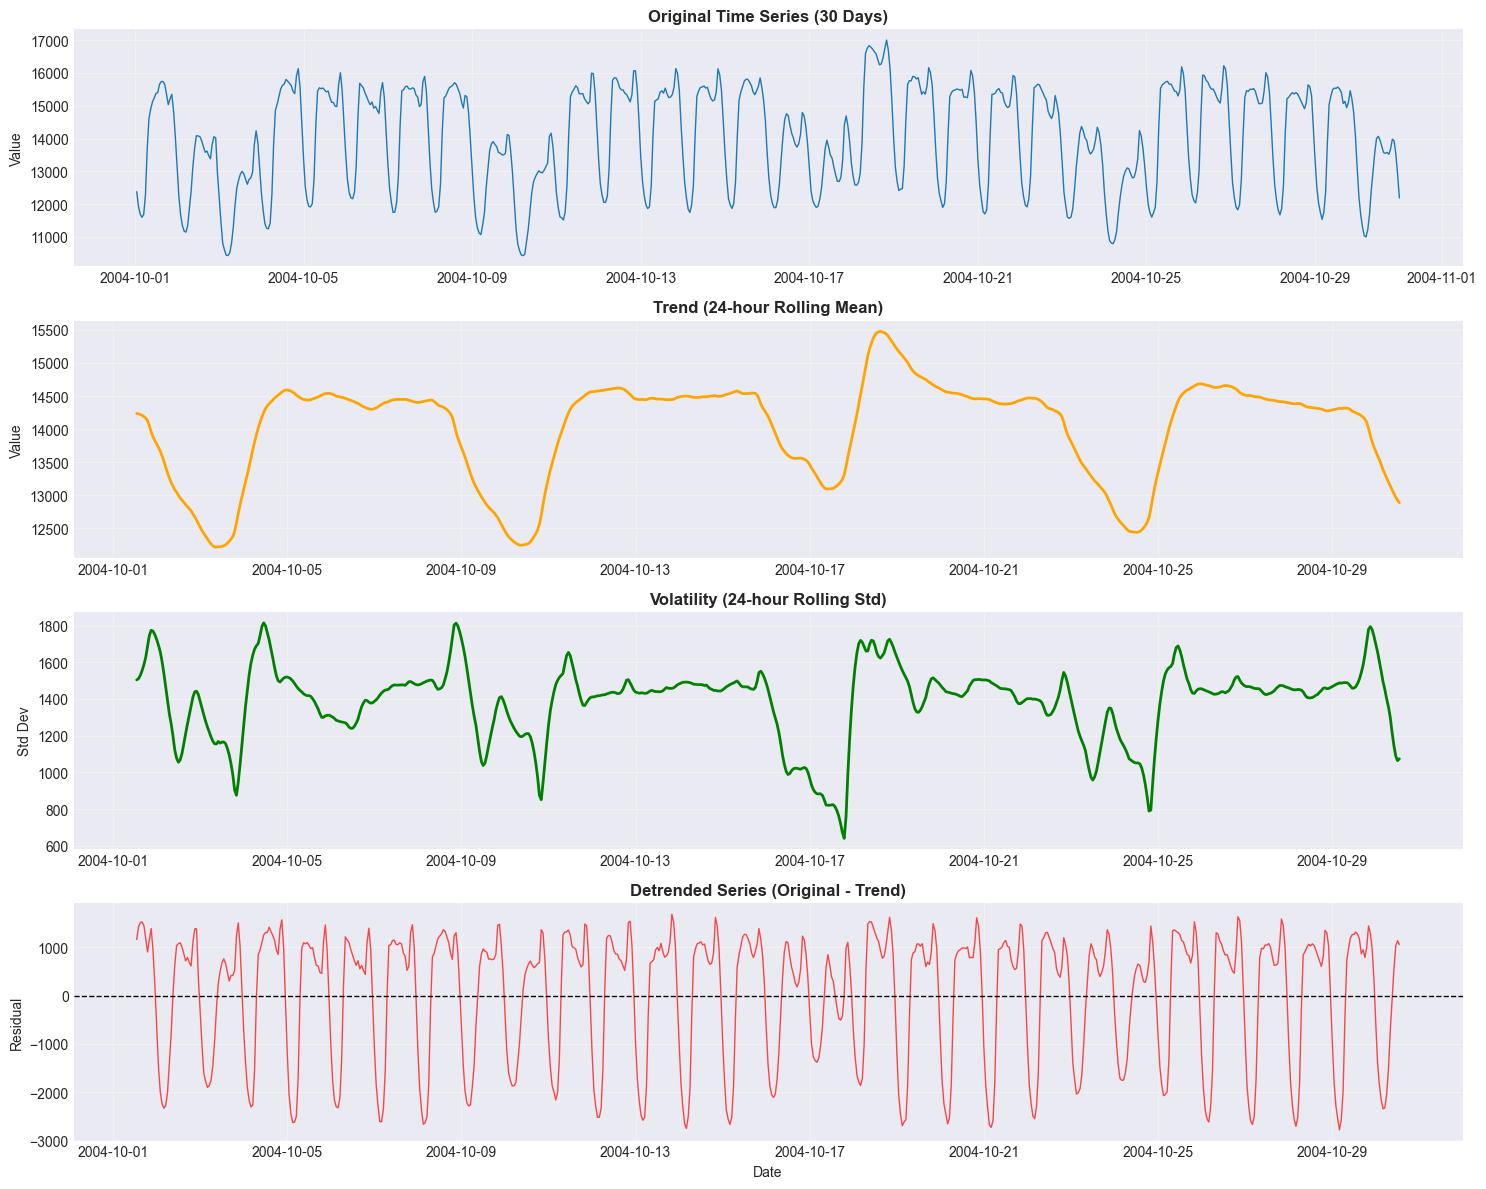

In [17]:
# Seasonal decomposition visualization
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original data (first 30 days)
sample_data = df_full.iloc[:24*30].copy()

axes[0].plot(sample_data['Datetime'], sample_data['AEP_MW'], linewidth=1)
axes[0].set_title('Original Time Series (30 Days)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Rolling mean (trend)
window = 24  # 24 hours
rolling_mean = sample_data['AEP_MW'].rolling(window=window, center=True).mean()
axes[1].plot(sample_data['Datetime'], rolling_mean, linewidth=2, color='orange')
axes[1].set_title('Trend (24-hour Rolling Mean)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Value')
axes[1].grid(True, alpha=0.3)

# Rolling std (volatility)
rolling_std = sample_data['AEP_MW'].rolling(window=window, center=True).std()
axes[2].plot(sample_data['Datetime'], rolling_std, linewidth=2, color='green')
axes[2].set_title('Volatility (24-hour Rolling Std)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Std Dev')
axes[2].grid(True, alpha=0.3)

# Detrended (residuals)
detrended = sample_data['AEP_MW'] - rolling_mean
axes[3].plot(sample_data['Datetime'], detrended, linewidth=1, color='red', alpha=0.7)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[3].set_title('Detrended Series (Original - Trend)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Residual')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()